In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import warnings

warnings.filterwarnings("ignore")

## Reading Data & Initial Exploration

The dataset is primarily centered around the housing market of Ankara, Turkey. The variables are explained below.

**id:** id of house

**fiyat:** sale price of house (TL)

**oda_salon_sayisi:** total number of rooms in the house

**net_m2:** size of house (in m2)

**bina_yasi:** age of the house (in years)

**isinma_tipi:** type of heating system for the house

**krediye_uygunluk:** situation of suitability for credit

**bulundugu_kat:** position of the house (floor number)

**banyo_sayisi:** number of bathrooms in the house

**ilce:** name of the district where the house locates in

**nüfus:** population of district where the house locates in

**eğitim:** education level of the district where the house locates in

**okuma_yazma_bilmeyen:** percentage of the illiterate population of the district where the house locates in

In [27]:
# Read data
df = pd.read_csv("/content/drive/MyDrive/ColabDatastore/METUSTAT/data.set.csv", sep=";", encoding = 'unicode_escape', decimal=",")

# Replace Turkish characters in column names
df = df.rename(columns={'eðitim':'egitim', 'okuma_yazma_bilmeyen,,': 'okuma_yazma_bilmeyen', 'nüfus':'nufus'})

# Droping id and Sutun1 as these have the same values with our index
df.drop(["Sütun1", "id"], axis=1, inplace=True)

# Convert column to float if dtype is object (string)
if df.okuma_yazma_bilmeyen.dtype == 'O':
  df["okuma_yazma_bilmeyen"] = pd.to_numeric(df["okuma_yazma_bilmeyen"].str[:-1].str.replace(',','.'), downcast='float', errors='coerce')

df.head()

,fiyat,oda_salon_sayisi,net_m2,bina_yasi,isinma_tipi,krediye_uygunluk,bulundugu_kat,banyo_sayisi,ilce,nufus,egitim,okuma_yazma_bilmeyen
0,275000.0,4.0,120.0,12.0,Kombi,Uygun,Kot 1,1.0,Çankaya,925828.0,Lisans,0.70
1,700000.0,3.0,88.0,0.0,Merkezi(PayÖlçer),Uygun,1. Kat,1.0,Çankaya,925828.0,Lisans,0.70
2,980000.0,5.0,230.0,30.0,Kombi,Uygun,3. Kat,2.0,Çankaya,925828.0,liSans,0.70
3,385000.0,4.0,120.0,22.0,Kombi,Uygun,2. Kat,1.0,Keçiören,938565.0,Lise,1.43
4,700000.0,5.0,150.0,0.0,Kombi,Uygun,Ara Kat,2.0,Çankaya,925828.0,Lisans,0.70


In [28]:
#Print min, max, mean and median for all numeric values to look for outliers
numeric_cols = ['fiyat', 'oda_salon_sayisi', 'net_m2', 'bina_yasi',
                'banyo_sayisi', 'nufus', 'okuma_yazma_bilmeyen']

for var in numeric_cols:
  print(f"Variable: {var}, Min: {df[var].min()}, Max: {df[var].max()}, Mean: {df[var].mean()}, Median: {df[var].median()}")

Variable: fiyat, Min: 325.0, Max: 8850000.0, Mean: 609542.0536562203, Median: 460000.0
Variable: oda_salon_sayisi, Min: 1.0, Max: 153.0, Mean: 4.327794920484216, Median: 4.0
Variable: net_m2, Min: -98.0, Max: 600.0, Mean: 130.33990030856873, Median: 120.0
Variable: bina_yasi, Min: 0.0, Max: 55.0, Mean: 16.164373814041745, Median: 16.0
Variable: banyo_sayisi, Min: 1.0, Max: 21.0, Mean: 1.4689131466540104, Median: 1.0
Variable: nufus, Min: 549108.0, Max: 938565.0, Mean: 873334.921689606, Median: 925828.0
Variable: okuma_yazma_bilmeyen, Min: 0.0, Max: 1.9, Mean: 1.1226179748635985, Median: 1.43


In [29]:
# Check rows with null values
df[df.isnull().any(axis=1)]

,fiyat,oda_salon_sayisi,net_m2,bina_yasi,isinma_tipi,krediye_uygunluk,bulundugu_kat,banyo_sayisi,ilce,nufus,egitim,okuma_yazma_bilmeyen
15,268000.0,3.0,110.0,25.0,Kombi,Uygun,Kot 1,1.0,Çankaya,NaN,Lisans,0.70
69,285000.0,NaN,110.0,28.0,Kombi,Uygun,2. Kat,1.0,Keçiören,938565.0,Lise,1.43
123,539000.0,4.0,125.0,22.0,NaN,Uygun,3. Kat,1.0,Çankaya,925828.0,Lisans,0.70
134,425000.0,3.0,115.0,22.0,Kombi,Uygun,3. Kat,1.0,Keçiören,NaN,Lise,1.43
263,735000.0,5.0,160.0,12.0,Kombi,Uygun,1. Kat,2.0,Keçiören,938565.0,Lise,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,595000.0,4.0,120.0,20.0,Kombi,Uygun,2. Kat,2.0,Çankaya,925828.0,NaN,0.70
4150,670000.0,5.0,185.0,2.0,Merkezi(PayÖlçer),Uygun,NaN,2.0,Çankaya,925828.0,Lisans,0.70
4204,NaN,4.0,115.0,7.0,Kombi,Uygun,4. Kat,1.0,Sincan,549108.0,Lise,1.44
4214,595000.0,4.0,100.0,50.0,Kombi,Uygun,Teras Katý,NaN,Çankaya,925828.0,Lisans,0.70


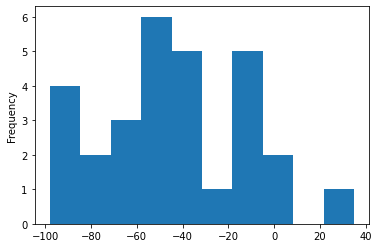

In [30]:
# m2 should not be less than ~40
df[df.net_m2 < 40]["net_m2"].plot(kind="hist")
plt.show()

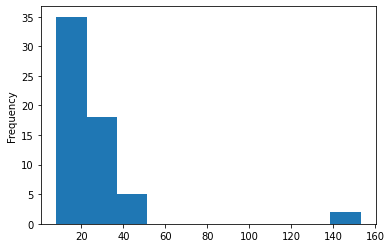

In [31]:
# We can see here that we have some outlier data, no house should have 140 rooms
df[df["oda_salon_sayisi"] > 7]["oda_salon_sayisi"].plot(kind="hist")
plt.show()

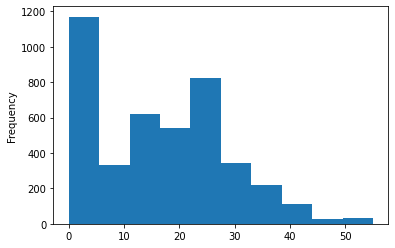

In [32]:
# Building age does not have significant wrong data entries
df["bina_yasi"].plot(kind="hist")
plt.show()

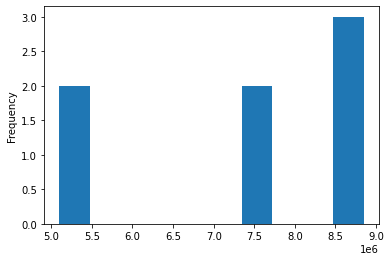

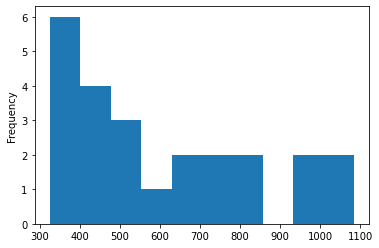

In [33]:
# We have some outliers in price but they do not seem to be wrong data points
# High prices are likely to be luxury houses and mansions 
# and low prices seem like rentals
df[(df["fiyat"] > 5_000_000)]["fiyat"].plot(kind="hist")
plt.show()
df[(df["fiyat"] < 10_000)]["fiyat"].plot(kind="hist")
plt.show()

## Preprocessing & Cleaning

In [34]:
# Fix typos in education
df['egitim'] = df['egitim'].str.replace('liS3','Lise')
df['egitim'] = df['egitim'].str.replace('liSans','Lisans')

# Fix typos in district
df['ilce'] = df['ilce'].str.replace('cankaya', 'Çankaya')

# Fill nan values according to district; 
# population, education and literacy all depend on district
for i, row in df.iterrows():
  if pd.isnull(row["ilce"]):
    df.loc[i, "ilce"] = df[df.nufus == row.nufus]["ilce"].value_counts().idxmax()
  if pd.isnull(row["nufus"]):
    df.loc[i, "nufus"] = df[df.ilce == row.ilce]["nufus"].value_counts().idxmax()
  if pd.isnull(row["egitim"]):
    df.loc[i, "egitim"] = df[df.ilce == row.ilce]["egitim"].value_counts().idxmax()
  if pd.isnull(row["okuma_yazma_bilmeyen"]):
    df.loc[i, "okuma_yazma_bilmeyen"] = df[df.ilce == row.ilce]["okuma_yazma_bilmeyen"].value_counts().idxmax()


In [35]:
# At this stage we make a copy of the original dataframe for exploration later on
df_copy = df.copy()

In [36]:
# Encoding education column as binary
df.loc[df["egitim"] == "Lise" , "egitim"] = 0
df.loc[df["egitim"] == "Lisans" , "egitim"] = 1

# Encoding heating type as integer
# We try to give the category with higher median prices a larger number
df.loc[df["isinma_tipi"] == "Kombi" , "isinma_tipi"] = 0
df.loc[df["isinma_tipi"] == "Merkezi(PayÖlçer)" , "isinma_tipi"] = 2
df.loc[df["isinma_tipi"] == "Merkezi" , "isinma_tipi"] = 1
df.loc[df["isinma_tipi"] == "KatKaloriferi" , "isinma_tipi"] = 1
df.loc[df["isinma_tipi"] == "Klima" , "isinma_tipi"] = 1
# Filling na values with 0 as they may be buildings with no heating
df.fillna({'isinma_tipi':0},inplace=True)

# Encoding and grouping building floor data
# Again we tried to give integer values according to these categories efffects on price
df.loc[df["bulundugu_kat"] == "Kot 1" , "bulundugu_kat"] = 0
df.loc[df["bulundugu_kat"] == "Yüksek Giriþ" , "bulundugu_kat"] = 0
df.loc[df["bulundugu_kat"] == "Kot 3" , "bulundugu_kat"] = 0
df.loc[df["bulundugu_kat"] == "Kot 2" , "bulundugu_kat"] = 0
df.loc[df["bulundugu_kat"] == "Bodrum" , "bulundugu_kat"] = 0
df.loc[df["bulundugu_kat"] == "1. Kat" , "bulundugu_kat"] = 1
df.loc[df["bulundugu_kat"] == "Bahçe Katý" , "bulundugu_kat"] = 1
df.loc[df["bulundugu_kat"] == "Zemin" , "bulundugu_kat"] = 1
df.loc[df["bulundugu_kat"] == "Giriþ Katý" , "bulundugu_kat"] = 1
df.loc[df["bulundugu_kat"] == "Çatý Katý" , "bulundugu_kat"] = 1
df.loc[df["bulundugu_kat"] == "2. Kat" , "bulundugu_kat"] = 2
df.loc[df["bulundugu_kat"] == "3. Kat" , "bulundugu_kat"] = 2
df.loc[df["bulundugu_kat"] == "4. Kat" , "bulundugu_kat"] = 2
df.loc[df["bulundugu_kat"] == "5. Kat" , "bulundugu_kat"] = 2
df.loc[df["bulundugu_kat"] == "Teras Katý" , "bulundugu_kat"] = 2
df.loc[df["bulundugu_kat"] == "En Üst Kat" , "bulundugu_kat"] = 2
df.loc[df["bulundugu_kat"] == "6. Kat" , "bulundugu_kat"] = 3
df.loc[df["bulundugu_kat"] == "7. Kat" , "bulundugu_kat"] = 3
df.loc[df["bulundugu_kat"] == "8. Kat" , "bulundugu_kat"] = 3
df.loc[df["bulundugu_kat"] == "9. Kat" , "bulundugu_kat"] = 3
df.loc[df["bulundugu_kat"] == "10. Kat" , "bulundugu_kat"] = 3
df.loc[df["bulundugu_kat"] == "Ara Kat" , "bulundugu_kat"] = 3
df.loc[df["bulundugu_kat"] == "11. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "12. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "13. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "14. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "15. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "16. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "17. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "18. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "19. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "20. Kat" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "21 ve üzeri" , "bulundugu_kat"] = 4
df.loc[df["bulundugu_kat"] == "Müstakil" , "bulundugu_kat"] = 5
df.loc[df["bulundugu_kat"] == "Villa Katý" , "bulundugu_kat"] = 5

# Filling na values with 1 as that is most likely value
df.fillna({'bulundugu_kat':1}, inplace=True)


# Grouping building age variables
# New values roughly correlate with demand
df.loc[df["bina_yasi"] < 6 , "bina_yasi"] = 3
df.loc[(df["bina_yasi"] >= 6 ) & (df["bina_yasi"] <= 15 ), "bina_yasi"] = 2
df.loc[(df["bina_yasi"] >= 16 ) & (df["bina_yasi"] <= 30 ), "bina_yasi"] = 1
df.loc[ df["bina_yasi"] > 30, "bina_yasi"] = 0

# Fillna with 1, the most likely value
df.fillna({'bina_yasi':1},inplace=True)


# Encoding and grouping districts
# Çankaya-Keçiören and Sincan-Mamak data points seem very similar
df.loc[(df["ilce"] == "Çankaya") | (df["ilce"] == "Keçiören") , "ilce"] = 1
df.loc[(df["ilce"] == "Sincan") | (df["ilce"] == "Mamak") , "ilce"] = 0


# Encoding credit as a binary variable
df.loc[df["krediye_uygunluk"] == "Uygun" , "krediye_uygunluk"] = 1
df.loc[df["krediye_uygunluk"] == "Uygun deðil" , "krediye_uygunluk"] = 0
df.fillna({'krediye_uygunluk':0},inplace=True)


# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [37]:
# Population and literacy data does not give us any new information
# We can derive the same information from district and education columns
df.drop(['nufus','okuma_yazma_bilmeyen'],axis=1,inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3605 entries, 0 to 4220
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fiyat             3595 non-null   float64
 1   oda_salon_sayisi  3596 non-null   float64
 2   net_m2            3596 non-null   float64
 3   bina_yasi         3605 non-null   float64
 4   isinma_tipi       3605 non-null   int64  
 5   krediye_uygunluk  3605 non-null   int64  
 6   bulundugu_kat     3605 non-null   int64  
 7   banyo_sayisi      3597 non-null   float64
 8   ilce              3605 non-null   object 
 9   egitim            3605 non-null   object 
dtypes: float64(5), int64(3), object(2)
memory usage: 309.8+ KB


In [39]:
df.describe()

,fiyat,oda_salon_sayisi,net_m2,bina_yasi,isinma_tipi,krediye_uygunluk,bulundugu_kat,banyo_sayisi
count,3.595000e+03,3596.000000,3596.000000,3605.000000,3605.000000,3605.000000,3605.000000,3597.000000
mean,6.158114e+05,4.365962,130.493326,1.691540,0.393897,0.980305,1.520943,1.480122
std,5.585668e+05,4.289989,53.299847,0.994015,0.675533,0.138969,0.987669,0.976337
min,3.250000e+02,1.000000,-98.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.250000e+05,4.000000,100.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,4.600000e+05,4.000000,120.000000,2.000000,0.000000,1.000000,2.000000,1.000000
75%,7.000000e+05,4.000000,145.000000,3.000000,1.000000,1.000000,2.000000,2.000000
max,8.850000e+06,153.000000,600.000000,3.000000,2.000000,1.000000,5.000000,21.000000


In [40]:
df.isna().sum()

fiyat               10
oda_salon_sayisi     9
net_m2               9
bina_yasi            0
isinma_tipi          0
krediye_uygunluk     0
bulundugu_kat        0
banyo_sayisi         8
ilce                 0
egitim               0
dtype: int64

In [41]:
# For data points with nan m2 values, we fill it with median m2 value 
# among other houses with similar room numbers
for i in df.loc[(df.net_m2.isna())].oda_salon_sayisi.unique():
  df.loc[(df.oda_salon_sayisi == i) & (df.net_m2.isna()), 'net_m2'] = df[df.oda_salon_sayisi == 4]['net_m2'].median()   

# Similarly, updating nan room numbers with median room number among similar m2
for i in df.loc[(df.oda_salon_sayisi.isna())].net_m2.unique():
  df.loc[(df.net_m2 == i) & (df.oda_salon_sayisi.isna()), 'oda_salon_sayisi'] = df[df.net_m2 == i]['oda_salon_sayisi'].median()


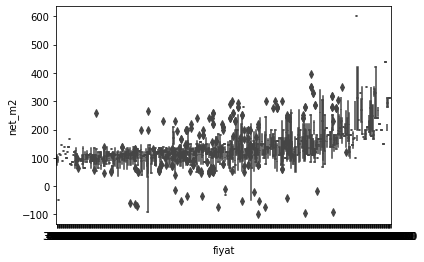

In [42]:
# Correlation and outliers from m2 - price
sns.boxplot(x=df['fiyat'],y=df['net_m2'])
plt.show()

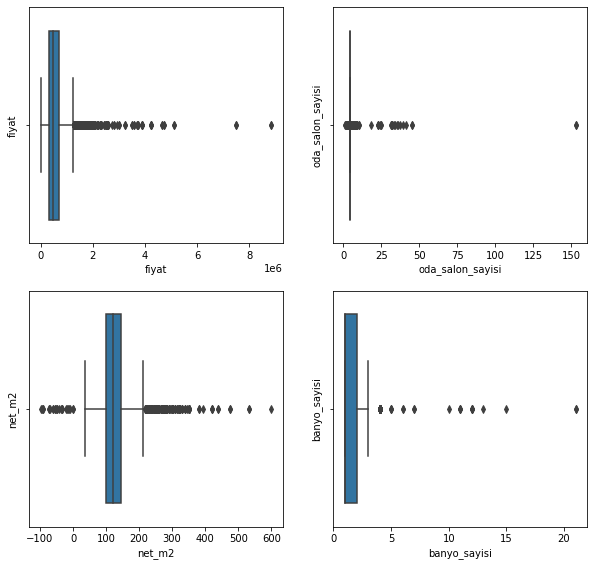

In [43]:
# Price, number of rooms and bathrooms, m2 are columns with significant outliers
# We can graph these columns to take a closer look
columns_num = ['fiyat', 'oda_salon_sayisi', 'net_m2', 'banyo_sayisi']
plt.figure(figsize=(10,20))
for i,col in enumerate(columns_num,1):
  plt.subplot(len(columns_num),2,i)
  sns.boxplot(x=df[col])
  plt.ylabel(col)
plt.show()

In [44]:
# Here we view tho outlier data points using standard deviation and z score
mean=df['oda_salon_sayisi'].mean()
std=df['oda_salon_sayisi'].std()
threshold = 7
outlier = [] 
for i in df['oda_salon_sayisi']: 
    z = (i-mean)/std 
    if z > threshold: 
        outlier.append(i) 
print('outlier in oda salon sayisi : ', outlier) 


mean=df['net_m2'].mean()
std=df['net_m2'].std()
threshold = 7
outlier = [] 
for i in df['net_m2']: 
    z = (i-mean)/std 
    if z > threshold: 
        outlier.append(i) 
print('outlier in m2 : ', outlier) 

mean=df['fiyat'].mean()
std=df['fiyat'].std()
threshold = 7
outlier = [] 
for i in df['fiyat']: 
    z = (i-mean)/std 
    if z > threshold: 
        outlier.append(i) 
print('outlier in fiyat : ', outlier) 

outlier in oda salon sayisi :  [35.0, 39.0, 37.0, 45.0, 153.0, 41.0, 36.0, 153.0, 45.0]
outlier in m2 :  [532.0, 532.0, 600.0]
outlier in fiyat :  [5100000.0, 4750000.0, 8850000.0, 4670000.0, 7500000.0, 4750000.0, 8850000.0, 4670000.0, 5100000.0, 7500000.0]


In [45]:
# We take houses smaller than 50 m2 as wrong entries and replace those values
# using a decision tree regressor built with houses larger than 70 m^2 
df_mod = df[df['net_m2'] > 70]

df_mod.dropna(inplace=True)

model = DecisionTreeRegressor(max_depth=3)

y = df_mod['net_m2']
X = df_mod[['fiyat','oda_salon_sayisi','banyo_sayisi']]

model.fit(X, y)

for i,row in df[df.net_m2 <50].iterrows():
  a = np.array([row['fiyat'],row['oda_salon_sayisi'],row['banyo_sayisi']]).reshape(1, -1)
  df.loc[i, "net_m2"] = model.predict(a)

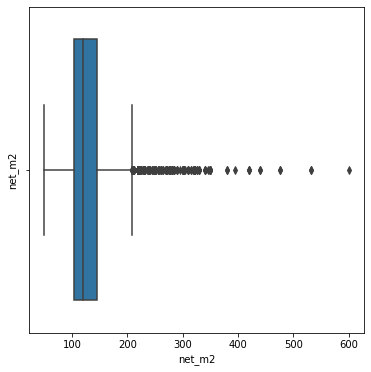

In [46]:
columns_num = ['net_m2']
plt.figure(figsize=(6,6))
for i,col in enumerate(columns_num,1):
  plt.subplot(len(columns_num),1,i)
  sns.boxplot(x=df[col])
  plt.ylabel(col)
plt.show()

In [47]:
df.isna().sum()

fiyat               10
oda_salon_sayisi     1
net_m2               1
bina_yasi            0
isinma_tipi          0
krediye_uygunluk     0
bulundugu_kat        0
banyo_sayisi         8
ilce                 0
egitim               0
dtype: int64

In [48]:
# Drop rows with missing price and rows with missing room number and m2
# as we cannot reliably fill those, and there are only ~20 such rows
df.dropna(inplace=True)

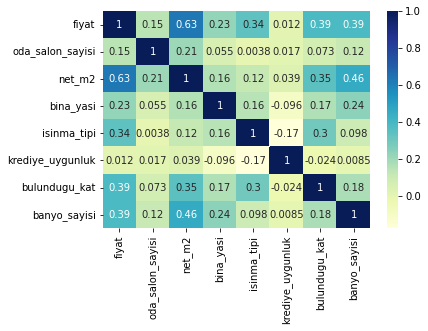

In [49]:
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

## Data Exploration & Insights 

### Viewing the relationship of Price & m^2 and examining the results of preprocessing on this

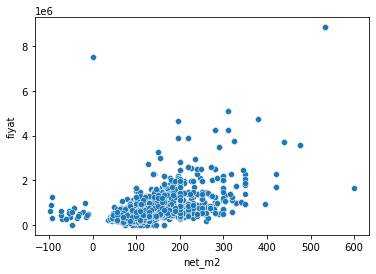

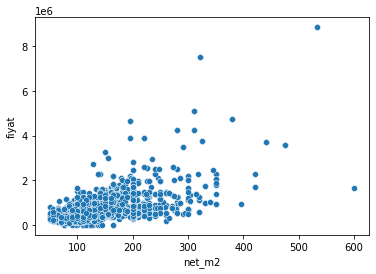

In [50]:
# Here we view price-m2 relationship before and after preprocessing
sns.scatterplot(data=df_copy, x="net_m2", y="fiyat")
plt.show()
sns.scatterplot(data=df, x="net_m2", y="fiyat")
plt.show()

We can see wrong entries moving closer to other data points on the lower left corner. This is especially easy to see with the building that is ~0 m2 and 7.8 mil price in the first graph. In the second graph it moved to ~350 m2, which is a reasonable assumption. 

One interesting observation is the relatively cheap building on the rightmost edge.

When we take a closer look we saw that the building has 18 rooms and it is relatively new.

It is likely for that building to be a dormitory or used for a similar purpose so we chose to leave it as is.


### Looking for apartment buildings in each district

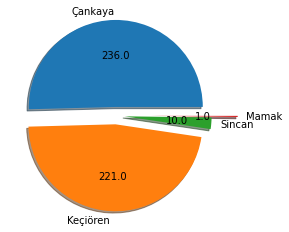

In [70]:
# Here we are trying to look for buildings that are higher than floor 2 and
# heated with 'merkezi'. These are likely to be apartment buildings.
df3 = df_copy.copy()

yuksek_katlar = ["2. Kat" , "3. Kat" , "4. Kat" , "5. Kat" , "Teras Katý", "En Üst Kat",
"6. Kat" , "7. Kat" , "8. Kat" , "9. Kat" , "10. Kat" , "Ara Kat" , "11. Kat" ,
"12. Kat" , "13. Kat" , "14. Kat" , "15. Kat" , "16. Kat" , "17. Kat" , 
"18. Kat" , "19. Kat" , "20. Kat" , "21 ve üzeri", "Çatý Katý"]

for kat in yuksek_katlar:
  df3.loc[df3["bulundugu_kat"] == kat , "bulundugu_kat"] = "Yuksek"

def absolute_value(val):
    a  = np.round(val/100.*y.sum(), 0)
    return a
  
dic = {}
for ilce in df3.ilce.unique():
  df_temp = df3[(df3.isinma_tipi == "Merkezi") & (df3.bulundugu_kat == "Yuksek") 
  & (df3.ilce == ilce)]
  dic[ilce] = df_temp.shape[0]

y = np.array(list(dic.values()))
mylabels = list(dic.keys())
myexplode = [0.1, 0.1, 0.1, 0.4]

plt.pie(y, labels=mylabels, explode=myexplode, shadow=True, autopct=absolute_value)
plt.show() 

We can see that Çankaya & Keçiören have a similar number of apartment buildings, and Mamak & Sincan have relatively few.

This further reinforces our decision to group these 2 districts together in preprocessing step.

### Finding the district with the highest number of student accomodations

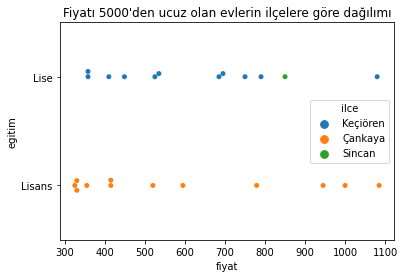

In [52]:
# In this part lets view houses cheaper than 5k according to district and education
df_temp = df_copy[df_copy.fiyat <= 5000]

ax = sns.swarmplot(data=df_temp, x="fiyat", y="egitim", hue="ilce")
ax.set_title("Fiyatı 5000'den ucuz olan evlerin ilçelere göre dağılımı")
plt.show()

Prices cheaper than 5000 are likely rentals and we can see Keçiören and Çankaya have a considerable number of such buildings.

Education level being 'bachelor' along with a large number of rentals might indicate that the area has a high number of students living there. 

If we think about what we can discern from other sources (such as google), this observation holds true.

### Searching for most affordable heating in each district

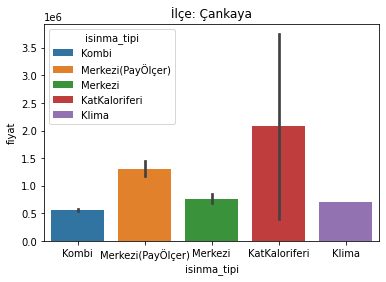

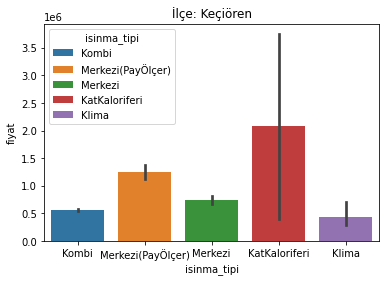

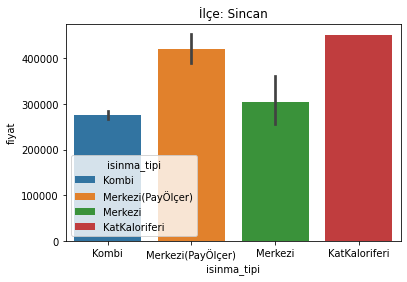

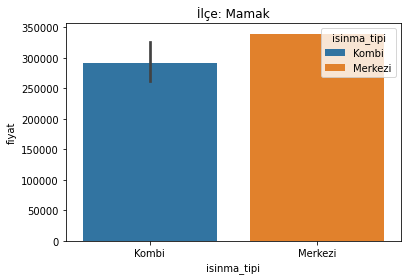

In [65]:
# In this part we are looking at the cheapest heating type according to district
ilce_list = df_copy["ilce"].unique()

for ilce in ilce_list:
  ax = sns.barplot(x="isinma_tipi", y="fiyat", data=df_copy[df_copy.ilce == ilce], hue="isinma_tipi", dodge=False)
  ax.set_title(f"İlçe: {ilce}")
  plt.show()

Kombi looks like the most affordable option in all districts. This is followed by Merkezi in all districts but Keçiören. In Keçiören, thw 2nd most affordable option is Klima.

In Çankaya and Keçiören, we see a wild variation in prices for Kat Kaloriferi. This is likely because the type of heating used in affordable and luxury houses, altough they look and function somewhat differently, are both labeled as 'Kat Kaloriferi'.

These graphs are also somewhat skewed because they include the houses with prices lower than 5000, the houses we previously assumed were rentals. It would make sense to draw different graphs for these groups.

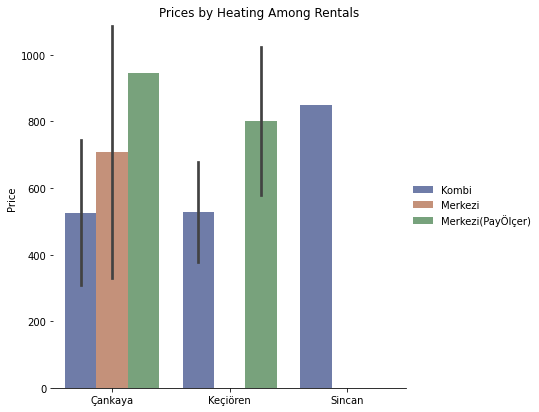

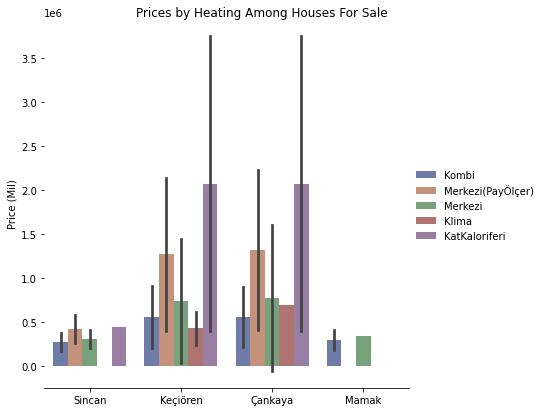

In [69]:
df_rental = df_copy.loc[df_copy.fiyat < 5000].sort_values('fiyat')
df_sale = df_copy.loc[df_copy.fiyat >= 5000].sort_values('fiyat')

# Draw a nested barplot by species and sex

g = sns.catplot(
    data=df_rental, kind="bar",
    x="ilce", y="fiyat", hue="isinma_tipi",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Price")
g.fig.suptitle('Prices by Heating Among Rentals')
g.legend.set_title("")
plt.show()

g = sns.catplot(
    data=df_sale, kind="bar",
    x="ilce", y="fiyat", hue="isinma_tipi",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Price (Mil)")
g.fig.suptitle('Prices by Heating Among Houses For Sale')
g.legend.set_title("")
plt.show()

This is a bit more clear. Kombi is still the cheapest option for all categories, Kombi and Merkezi prices are much closer for every district and average price of Klima houses is actually lower for Keçiören.